# **STORE SALES - TIME SERIES FORECASTING**
## Machine Learning Final Project


This project aims to build a model that predicts future sales for a retail store chain. Accurate forecasts will help optimize inventory planning and promotional strategies.

----
## Problem Statement
#### Objective

To forecast future **sales (`SALES`)** for each product category (**`FAMILY`**) sold at each of Favorita’s stores.  
This will contribute to:
- Store inventory planning
- Adjustment of the number of orders

#### Problem Type

- Time-series regression problem

#### Objective Variable (Target)

- `SALES`: Sales volume for each store, product category, and date  
  (Note: values may include decimal points)

#### Evaluation Metric

- **RMSLE** (Root Mean Squared Logarithmic Error):  
  Calculated using the root mean square of the logarithmic difference between forecast and actual sales.

#### Data Description

- `train.csv`:  
  Training data containing:
  - Store number
  - Product category
  - Date
  - Sales
  - Promotion information, etc.

- `test.csv`:  
  Test data for forecasting (does **not** include the target `SALES`).

- `stores.csv`:  
  Detailed store information, including:
  - City
  - State
  - Store type
  - Cluster

- `oil.csv`:  
  Time-series data of WTI crude oil prices.

- `holidays_events.csv`:  
  Information on holidays and special events.

- `transactions.csv`:  
  Daily number of transactions per store.

## Initial Data exploration

In [1]:
from pandasql import sqldf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read input data
train = pd.read_csv('data/train.zip', compression='zip')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
oil = pd.read_csv('data/oil.csv')
holidays_events = pd.read_csv('data/holidays_events.csv')
transactions = pd.read_csv('data/transactions.csv')

In [3]:
print("Train Data:")
print(train.head())
print(train.describe())
print(train.info())

print("\nTest Data:")
print(test.head())
print(test.describe())
print(test.info())

print("\nStores Data:")
print(stores.head())
print(stores.describe())
print(stores.info())

print("\nOil Data:")
print(oil.head())
print(oil.describe())
print(oil.info())

print("\nHolidays and Events Data:")
print(holidays_events.head())
print(holidays_events.describe())
print(holidays_events.info())

print("\nTransactions Data:")
print(transactions.head())
print(transactions.describe())
print(transactions.info())

print("\nSample Submission:")
print(sample_submission.head())

Train Data:
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entrie

## Data Preprocessing

### Handle missing values

In [6]:
# Find missing values:

print("Train Data:")
print(train.isnull().sum())

print("\nTest Data:")
print(test.isnull().sum())

print("\nStores Data:")
print(stores.isnull().sum())

print("\nOil Data:")
print(oil.isnull().sum())

print("\nHolidays and Events Data:")
print(holidays_events.isnull().sum())

print("\nTransactions Data:")
print(transactions.isnull().sum())

Train Data:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Test Data:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Stores Data:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Oil Data:
date           0
dcoilwtico    43
dtype: int64

Holidays and Events Data:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Transactions Data:
date            0
store_nbr       0
transactions    0
dtype: int64


#### Missing values in Oil

In [8]:
oil.head(16)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


In [9]:
# dcoilwtico mean
oil['dcoilwtico'].mean()

67.71436595744682

In [10]:
# fill missing values with interpolate
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate()

# Find missing values
print(oil.isnull().sum())

date          0
dcoilwtico    1
dtype: int64


In [11]:
oil[oil.isna().any(axis=1)]

,date,dcoilwtico
0,2013-01-01,NaN


In [12]:
# bfill to clean 1st entry as nan
oil['dcoilwtico'] = oil['dcoilwtico'].bfill()

# Find missing values
print(oil.isnull().sum())

date          0
dcoilwtico    0
dtype: int64


In [13]:
oil.head(16)

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


### Find inconsistencies

In [15]:
# Find duplicate rows

print(f"duplicates in train are: {len(train[train.duplicated()])}")
print(f"duplicates in test are: {len(test[test.duplicated()])}")
print(f"duplicates in stores are: {len(stores[stores.duplicated()])}")
print(f"duplicates in oil are: {len(oil[oil.duplicated()])}")
print(f"duplicates in holidays_events are: {len(holidays_events[holidays_events.duplicated()])}")
print(f"duplicates in transactions are: {len(transactions[transactions.duplicated()])}")

duplicates in train are: 0
duplicates in test are: 0
duplicates in stores are: 0
duplicates in oil are: 0
duplicates in holidays_events are: 0
duplicates in transactions are: 0


In [16]:
# Find negative sales
print("Negative sales count in train:", (train['sales'] < 0).sum())

Negative sales count in train: 0


In [17]:
# Find is stores match between dataset
print("Stores in train but not in stores.csv:", set(train['store_nbr']) - set(stores['store_nbr']), )
print("Stores in test but not in stores.csv:", set(test['store_nbr']) - set(stores['store_nbr']))
print("Stores in transactions but not in stores.csv:", set(transactions['store_nbr']) - set(stores['store_nbr']))

Stores in train but not in stores.csv: set()
Stores in test but not in stores.csv: set()
Stores in transactions but not in stores.csv: set()


All the data is cleaned and there are not inconsistencies.

## Exploratory Data Analysis

In [20]:
# date to datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

In [21]:
# Range from dates
print("Train date range:", train['date'].min(), "to", train['date'].max())
print("Test date range:", test['date'].min(), "to", test['date'].max())

Train date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Test date range: 2017-08-16 00:00:00 to 2017-08-31 00:00:00


### Sales and Oil prices

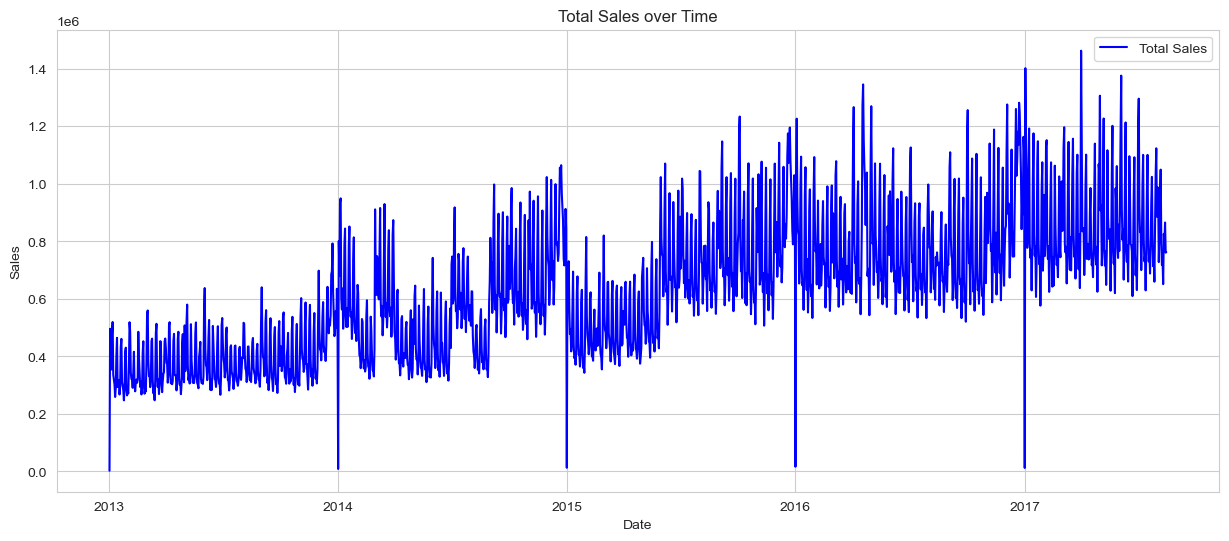

In [23]:
# Total Sales Over Time
daily_sales = train.groupby('date')['sales'].sum().reset_index()

sb.set_style("whitegrid")
plt.figure(figsize=(15, 6))
sb.lineplot(data=daily_sales, x='date', y='sales', color='blue', label="Total Sales")
plt.title("Total Sales over Time")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.show()

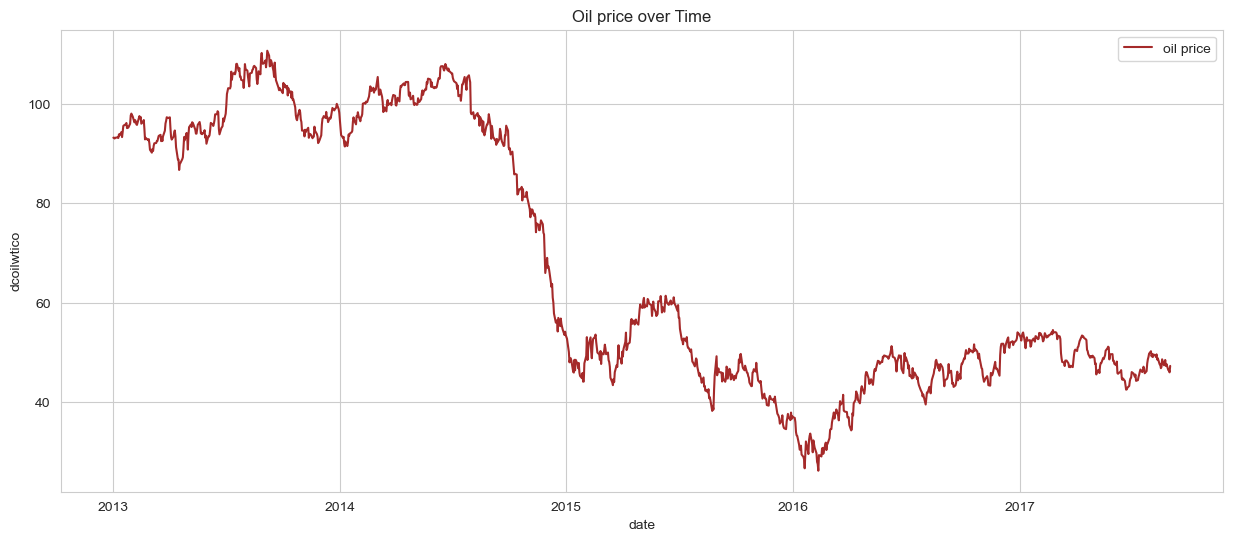

In [24]:
# Lineplot from oil over time
plt.figure(figsize=(15,6))
sb.lineplot(data=oil, y='dcoilwtico', x='date', color='brown', label="oil price")
plt.title("Oil price over Time") 
plt.show()

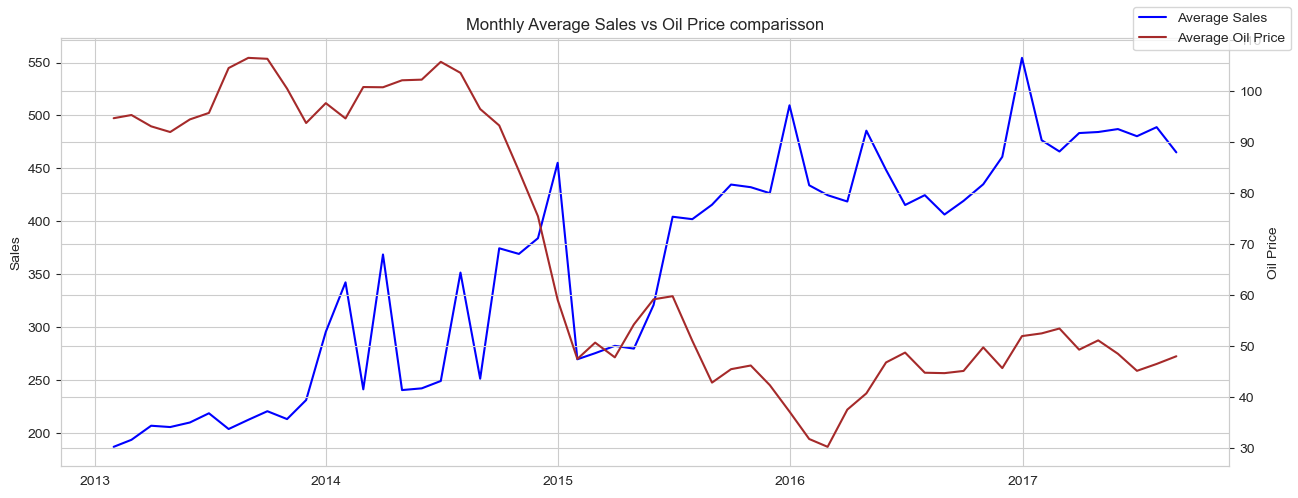

In [25]:
# Resample by month
monthly_sales = train.resample('M', on='date')['sales'].mean()
monthly_oil = oil.resample('M', on='date')['dcoilwtico'].mean()

fig, ax1 = plt.subplots(figsize=(13, 5))
# Plot Sales
ax1.plot(monthly_sales.index, monthly_sales.values, color='blue', label='Average Sales')
ax1.set_ylabel('Sales')

# Plot Oil price
ax2 = ax1.twinx()
ax2.plot(monthly_oil.index, monthly_oil.values, color='brown', label='Average Oil Price')
ax2.set_ylabel('Oil Price')

plt.title('Monthly Average Sales vs Oil Price comparisson')
fig.tight_layout()
fig.legend()
plt.show()

After 2014, oil prices dropped significantly, while average sales began to rise steadily. This suggests that lower oil prices may have supported higher consumer spending or reduced transportation costs. Although sales show some seasonal changes, the overall trend moves in the opposite direction of oil prices.

### Total Sales by Store

In [28]:
# Unique values from store_nbr
print("stores:", train['store_nbr'].nunique())

stores: 54


In [29]:
# Grouping by Stores (TOP)
top_store_sales = train.groupby('store_nbr')[['sales']].sum().sort_values('sales', ascending=False).head(5)
print(top_store_sales)

                  sales
store_nbr              
44         6.208755e+07
45         5.449801e+07
47         5.094831e+07
3          5.048191e+07
49         4.342010e+07


In [30]:
# Grouping by Stores (BOTTOM)
bottom_store_sales = train.groupby('store_nbr')[['sales']].sum().sort_values('sales', ascending=True).head(5)
print(bottom_store_sales)

                  sales
store_nbr              
52         2.696170e+06
22         4.090202e+06
32         5.951796e+06
30         7.382074e+06
35         7.676679e+06


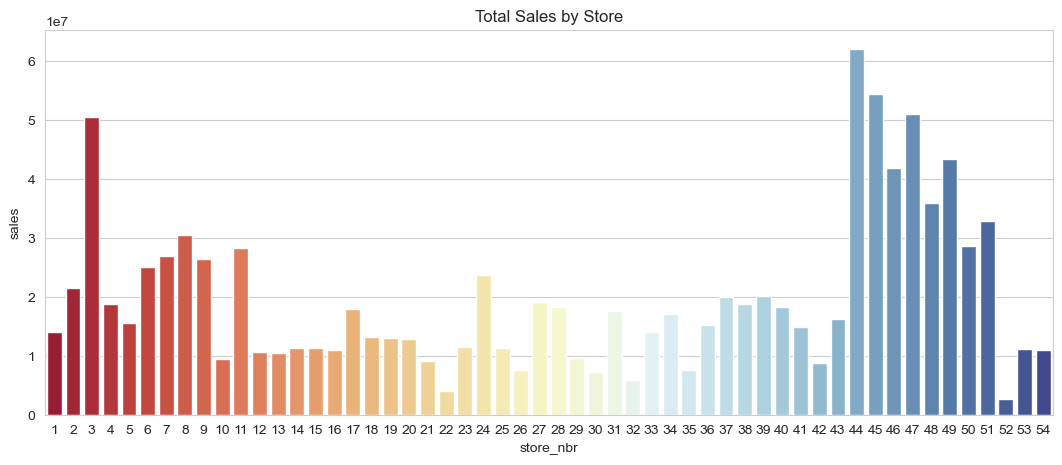

In [31]:
# Grouping by Stores
store_sales = train.groupby('store_nbr')[['sales']].sum()

# Barplot from total sales by store
plt.figure(figsize=(13,5))
sb.barplot(data=store_sales, y='sales', x='store_nbr', palette='RdYlBu')
plt.title("Total Sales by Store")
plt.show()

### Total Sales by Type and Cluster

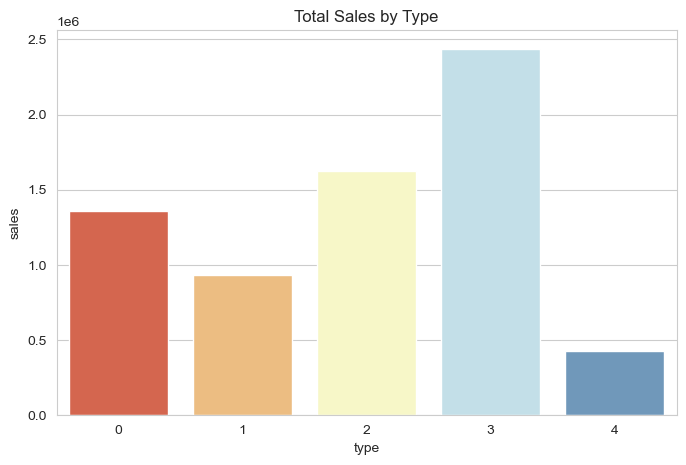

In [226]:
# Grouping by Type
store_sales = train.groupby('type')[['sales']].sum()

# Barplot from total sales by type
plt.figure(figsize=(8,5))
sb.barplot(data=store_sales, y='sales', x='type', palette='RdYlBu')
plt.title("Total Sales by Type")
plt.show()

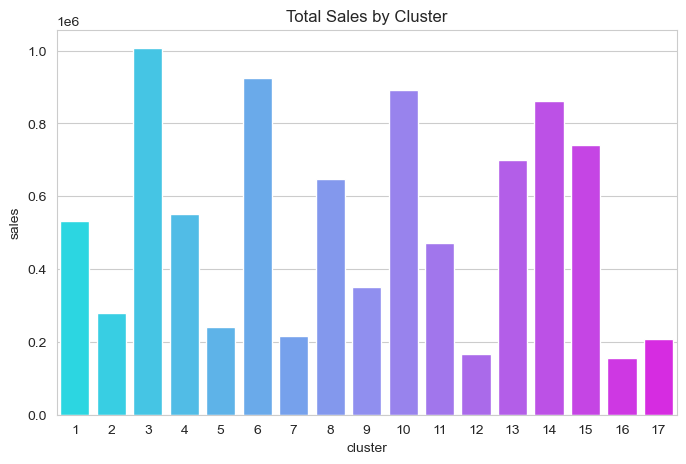

In [228]:
# Grouping by Cluster
store_sales = merged_df.groupby('cluster')[['sales']].sum()

# Barplot from total sales by cluster
plt.figure(figsize=(8,5))
sb.barplot(data=store_sales, y='sales', x='cluster', palette='cool')
plt.title("Total Sales by Cluster")
plt.show()

### Total Sales by Family over the time

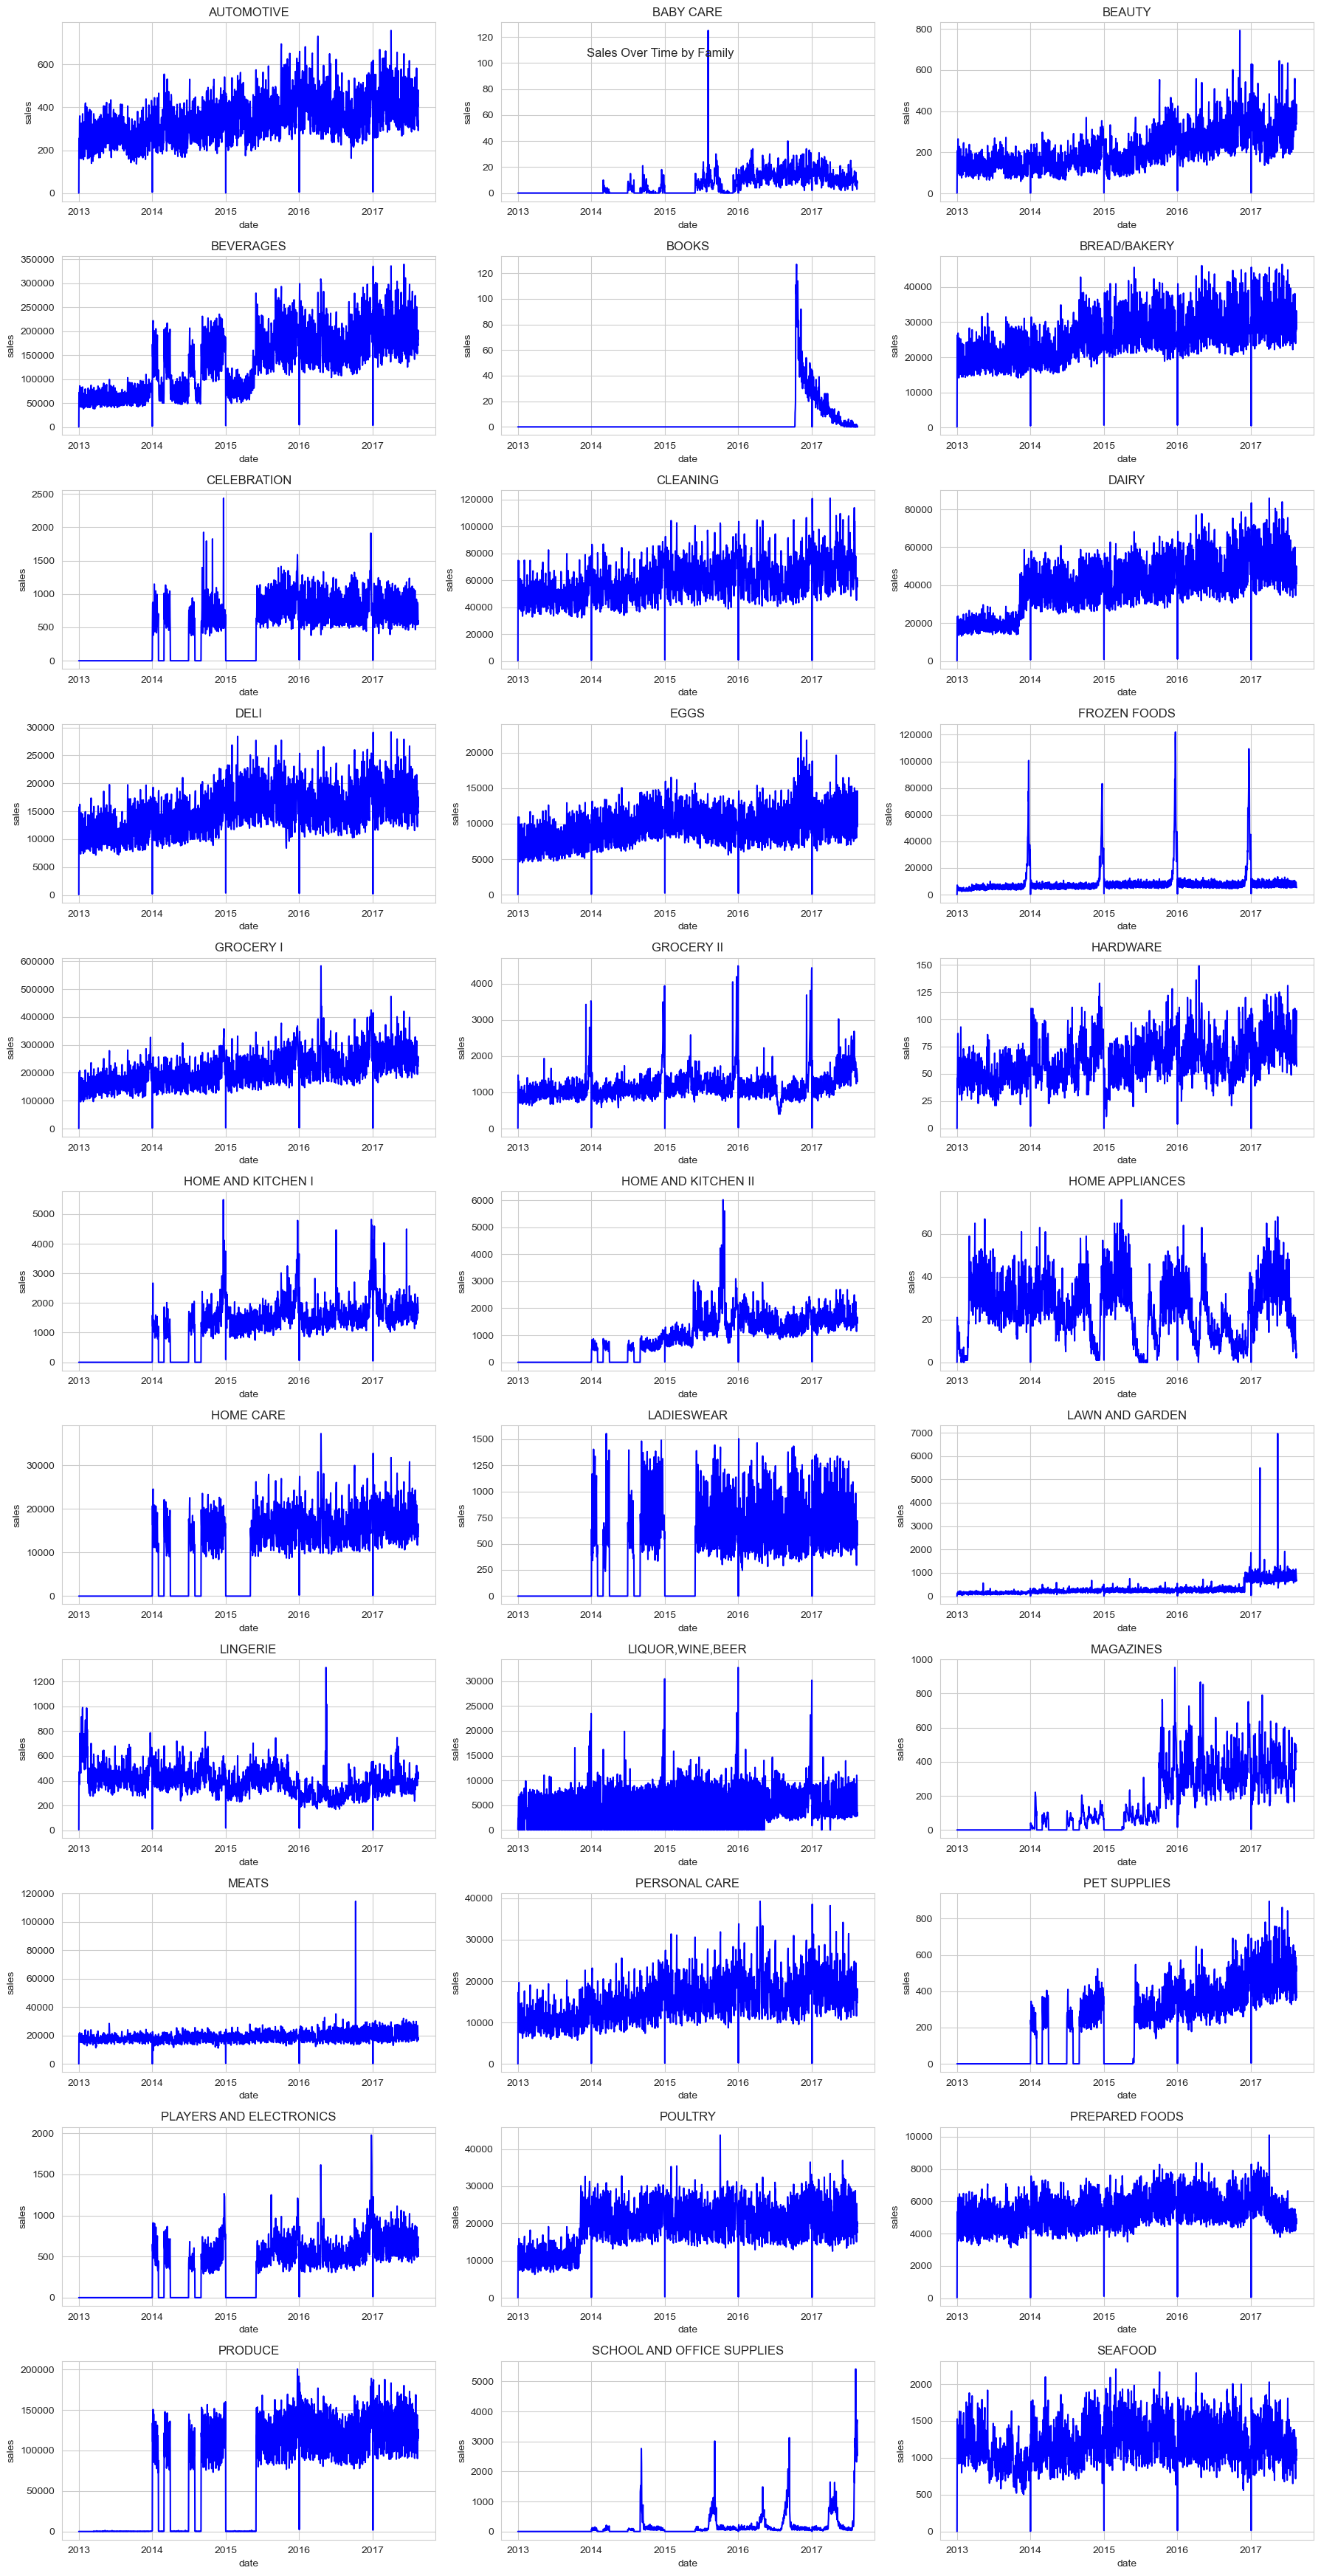

In [33]:
# Total Sales
family_sales = train.groupby(['date', 'family'])[['sales']].sum().reset_index()
families = sorted(family_sales['family'].unique())

# lineplot from total sales by store
fig, axes = plt.subplots(11, 3, figsize=(18, 35))
axes = axes.flatten()

# Plot each family
for i, fam in enumerate(families):
    ax = axes[i]
    sb.lineplot(data=family_sales[family_sales['family'] == fam], x='date', y='sales', ax=ax, color='blue')
    ax.set_title(fam)

plt.tight_layout()
plt.suptitle("Sales Over Time by Family")
plt.show()

Between 2013 and 2017, sales for drinks, groceries, and cleaning products kept growing steadily. Frozen foods, school supplies, and liquor sold more during certain times of the year. On the other hand, book and baby product sales dropped a lot, while personal care and pet products became more popular over time.

Overall, the data reflects consistent growth in consumer spending, especially on essentials and lifestyle products.

### Finding Seasonality in Sales by Weekday, Month or Year

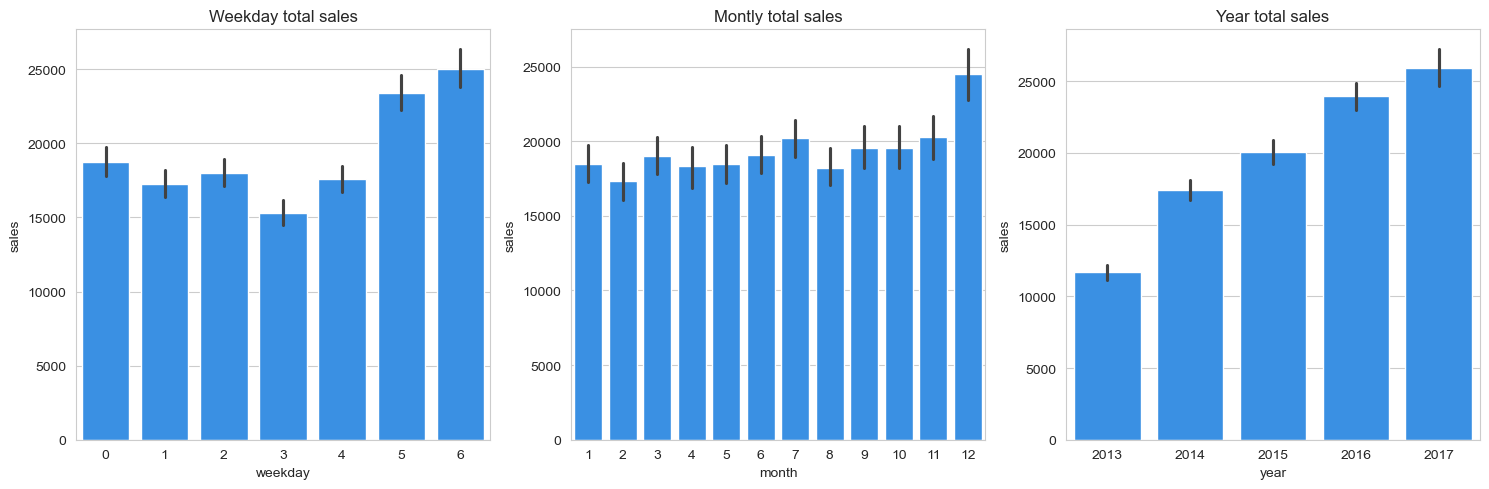

In [36]:
family_sales['month'] = family_sales['date'].dt.month
family_sales['weekday'] = family_sales['date'].dt.weekday
family_sales['year'] = family_sales['date'].dt.year

# Finding seasonality
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

sb.barplot(data=family_sales, x='weekday', y='sales', ax=axes[0], color='dodgerblue')
axes[0].set_title("Weekday total sales")

sb.barplot(data=family_sales, x='month', y='sales', ax=axes[1], color='dodgerblue')
axes[1].set_title("Montly total sales")

sb.barplot(data=family_sales, x='year', y='sales', ax=axes[2], color='dodgerblue')
axes[2].set_title("Year total sales")

plt.tight_layout()
plt.show()

Sales peaked on weekends, especially Sundays. December was the top-selling month, likely driven by holiday shopping. Yearly sales showed an increasing trend from 2013 to 2017, indicating overall business growth.

### Holidays impact on Sales

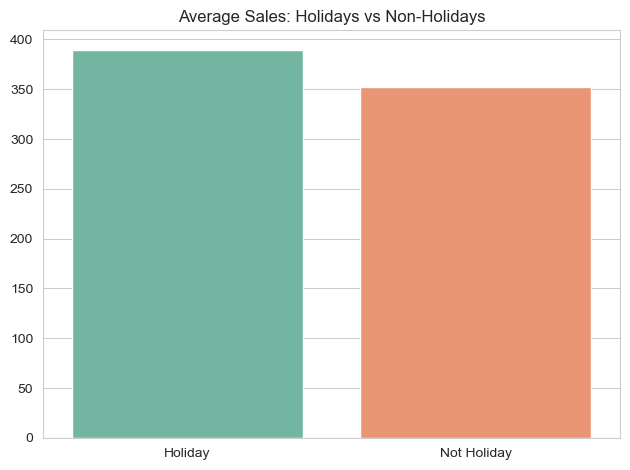

In [39]:
holiday_avg = train[train['date'].isin(holidays_events['date'])]['sales'].mean()
non_holiday_avg = train[~train['date'].isin(holidays_events['date'])]['sales'].mean()

# Plot
sb.barplot(x=['Holiday', 'Not Holiday'], y=[holiday_avg, non_holiday_avg], palette='Set2')
plt.title('Average Sales: Holidays vs Non-Holidays')
plt.tight_layout()
plt.show()

Sales were noticeably higher on holidays, suggesting that special dates drive a significant boost in customer purchases.

## Feature Engineering

### Handle holiday dataset 

In [43]:
print(holidays_events.shape)
holidays_events.head()

(350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [44]:
holidays_events['type'].value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

In [45]:
holidays_events.drop(holidays_events[(holidays_events['type'] == 'Work Day') | (holidays_events['transferred'] == True)].index,inplace=True)
holidays_events.drop('transferred', axis=1, inplace=True)

holidays_events['type'].value_counts()

type
Holiday       209
Event          56
Additional     51
Transfer       12
Bridge          5
Name: count, dtype: int64

In [46]:
# Create a column Holiday flag
holidays_events['holiday_flg'] = 1

### Merge datasets

In [48]:
train['is_test'] = 0
test['is_test'] = 1

In [49]:
#merged holiday and oil data with train data
exclude_col = 'date'

new_columns = {col: col + '_holiday' for col in holidays_events.columns if col != exclude_col}

holidays_events = holidays_events.rename(columns=new_columns)


merged_df = pd.concat([train, test], ignore_index=True)
merged_df = pd.merge(merged_df, holidays_events, on='date', how='left')
merged_df = pd.merge(merged_df, oil, on='date', how='left')


merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,is_test,type_holiday,locale_holiday,locale_name_holiday,description_holiday,holiday_flg_holiday,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Holiday,National,Ecuador,Primer dia del ano,1.0,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Holiday,National,Ecuador,Primer dia del ano,1.0,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Holiday,National,Ecuador,Primer dia del ano,1.0,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Holiday,National,Ecuador,Primer dia del ano,1.0,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,0,Holiday,National,Ecuador,Primer dia del ano,1.0,93.14


In [50]:
print(merged_df.shape)
merged_df.isnull().sum()

(3081078, 13)


id                           0
date                         0
store_nbr                    0
family                       0
sales                    28512
onpromotion                  0
is_test                      0
type_holiday           2601720
locale_holiday         2601720
locale_name_holiday    2601720
description_holiday    2601720
holiday_flg_holiday    2601720
dcoilwtico              883872
dtype: int64

In [51]:
merged_df[merged_df['dcoilwtico'].isnull()]

,id,date,store_nbr,family,sales,onpromotion,is_test,type_holiday,locale_holiday,locale_name_holiday,description_holiday,holiday_flg_holiday,dcoilwtico
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
7129,7129,2013-01-05,1,BABY CARE,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
7130,7130,2013-01-05,1,BEAUTY,3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
7131,7131,2013-01-05,1,BEVERAGES,1160.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
7132,7132,2013-01-05,1,BOOKS,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3073945,3022267,2017-08-27,9,POULTRY,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN
3073946,3022268,2017-08-27,9,PREPARED FOODS,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN
3073947,3022269,2017-08-27,9,PRODUCE,NaN,2,1,NaN,NaN,NaN,NaN,NaN,NaN
3073948,3022270,2017-08-27,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,1,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
#Handle missing values of merged data by filling 'not holiday'
columns_to_fill = ['type_holiday', 'locale_holiday', 'locale_name_holiday', 'description_holiday']
merged_df[columns_to_fill] = merged_df[columns_to_fill].fillna('Not holiday')
merged_df['holiday_flg_holiday'] = merged_df['holiday_flg_holiday'].fillna(0)

In [53]:
#oil price data which is dcoilwtico have some missing dates, so fill them by mean of value of previous/next date
date_oil = merged_df[['date', 'dcoilwtico']].drop_duplicates(subset='date')
date_oil = date_oil.sort_values('date').reset_index(drop=True)

date_oil['dcoilwtico'] = date_oil['dcoilwtico'].interpolate(method='linear', limit_direction='both')
date_oil.head()

,date,dcoilwtico
0,2013-01-01,93.140000
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667


In [54]:
merged_df = merged_df.drop(columns=['dcoilwtico'])

merged_df = pd.merge(merged_df, date_oil, on='date', how='left')
print(merged_df.shape)
merged_df.isnull().sum()

(3081078, 13)


id                         0
date                       0
store_nbr                  0
family                     0
sales                  28512
onpromotion                0
is_test                    0
type_holiday               0
locale_holiday             0
locale_name_holiday        0
description_holiday        0
holiday_flg_holiday        0
dcoilwtico                 0
dtype: int64

In [55]:
# Create time-based features
merged_df['year'] = merged_df['date'].dt.year
merged_df['month'] = merged_df['date'].dt.month
merged_df['day'] = merged_df['date'].dt.day
merged_df['dayofweek'] = merged_df['date'].dt.dayofweek
merged_df['weekofyear'] = merged_df['date'].dt.isocalendar().week
merged_df['is_weekend'] = (merged_df['dayofweek'] >= 5).astype(int)
merged_df['is_payday'] = merged_df['day'].isin([1, 15, 30]).astype(int)

# Ecuador Seasons
def get_ecuador_season(month):
    if month in [12, 1, 2, 3, 4, 5]:
        return 'wet'    # Rainy Season
    else:
        return 'dry'    # Dry Season

merged_df['season'] = merged_df['month'].apply(get_ecuador_season)
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,is_test,type_holiday,locale_holiday,locale_name_holiday,...,holiday_flg_holiday,dcoilwtico,year,month,day,dayofweek,weekofyear,is_weekend,is_payday,season
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Holiday,National,Ecuador,...,1.0,93.14,2013,1,1,1,1,0,1,wet
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Holiday,National,Ecuador,...,1.0,93.14,2013,1,1,1,1,0,1,wet
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Holiday,National,Ecuador,...,1.0,93.14,2013,1,1,1,1,0,1,wet
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Holiday,National,Ecuador,...,1.0,93.14,2013,1,1,1,1,0,1,wet
4,4,2013-01-01,1,BOOKS,0.0,0,0,Holiday,National,Ecuador,...,1.0,93.14,2013,1,1,1,1,0,1,wet


### Considering cluster information

In [57]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [58]:
stores_info = stores[['store_nbr', 'type', 'cluster']]

# Merge with merged_df
merged_df = merged_df.merge(stores_info, on='store_nbr', how='left')
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,is_test,type_holiday,locale_holiday,locale_name_holiday,...,year,month,day,dayofweek,weekofyear,is_weekend,is_payday,season,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Holiday,National,Ecuador,...,2013,1,1,1,1,0,1,wet,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Holiday,National,Ecuador,...,2013,1,1,1,1,0,1,wet,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Holiday,National,Ecuador,...,2013,1,1,1,1,0,1,wet,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Holiday,National,Ecuador,...,2013,1,1,1,1,0,1,wet,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,0,Holiday,National,Ecuador,...,2013,1,1,1,1,0,1,wet,D,13


In [59]:
# Find null values
merged_df.isnull().sum()

id                         0
date                       0
store_nbr                  0
family                     0
sales                  28512
onpromotion                0
is_test                    0
type_holiday               0
locale_holiday             0
locale_name_holiday        0
description_holiday        0
holiday_flg_holiday        0
dcoilwtico                 0
year                       0
month                      0
day                        0
dayofweek                  0
weekofyear                 0
is_weekend                 0
is_payday                  0
season                     0
type                       0
cluster                    0
dtype: int64

### Important sales/event

In [61]:
# Lowercase descriptions
merged_df['description_holiday'] = merged_df['description_holiday'].str.lower()

# Important keywords (horizontal)
important_keywords = ['black friday', 'navidad', 'madre', 'carnaval', 'ano nuevo', 'primer dia del ano', 'padre']

# Create big event flag
merged_df['is_big_event'] = merged_df['description_holiday'].apply(lambda x: int(any(word in x for word in important_keywords)))

# Also manually mark February 14 and December 31 as big events
merged_df.loc[(merged_df['date'].dt.month == 2) & (merged_df['date'].dt.day == 14), 'is_big_event'] = 1
merged_df.loc[(merged_df['date'].dt.month == 12) & (merged_df['date'].dt.day == 31), 'is_big_event'] = 1
merged_df.loc[(merged_df['date'].dt.month == 1) & (merged_df['date'].dt.day == 1), 'is_big_event'] = 1
merged_df['is_big_event'] = merged_df['is_big_event'].fillna(0)

merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,is_test,type_holiday,locale_holiday,locale_name_holiday,...,month,day,dayofweek,weekofyear,is_weekend,is_payday,season,type,cluster,is_big_event
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,1,0,1,wet,D,13,1
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,1,0,1,wet,D,13,1
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,1,0,1,wet,D,13,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,1,0,1,wet,D,13,1
4,4,2013-01-01,1,BOOKS,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,1,0,1,wet,D,13,1


In [62]:
# Define earthquake keywords
important_keywords = ['terremoto', 'manabi', 'manabí']

# is_earthquake_event
merged_df['is_earthquake_event'] = merged_df['description_holiday'].apply(lambda x: int(any(word in x for word in important_keywords)))
merged_df['is_earthquake_event'] = merged_df['is_earthquake_event'].fillna(0)

merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,is_test,type_holiday,locale_holiday,locale_name_holiday,...,day,dayofweek,weekofyear,is_weekend,is_payday,season,type,cluster,is_big_event,is_earthquake_event
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,0,1,wet,D,13,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,0,1,wet,D,13,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,0,1,wet,D,13,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,0,1,wet,D,13,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,0,1,wet,D,13,1,0


### Encoding

In [64]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081078 entries, 0 to 3081077
Data columns (total 25 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   date                 datetime64[ns]
 2   store_nbr            int64         
 3   family               object        
 4   sales                float64       
 5   onpromotion          int64         
 6   is_test              int64         
 7   type_holiday         object        
 8   locale_holiday       object        
 9   locale_name_holiday  object        
 10  description_holiday  object        
 11  holiday_flg_holiday  float64       
 12  dcoilwtico           float64       
 13  year                 int32         
 14  month                int32         
 15  day                  int32         
 16  dayofweek            int32         
 17  weekofyear           UInt32        
 18  is_weekend           int32         
 19  is_payday            

In [65]:
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,is_test,type_holiday,locale_holiday,locale_name_holiday,...,day,dayofweek,weekofyear,is_weekend,is_payday,season,type,cluster,is_big_event,is_earthquake_event
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,0,1,wet,D,13,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,0,1,wet,D,13,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,0,1,wet,D,13,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,0,1,wet,D,13,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,0,Holiday,National,Ecuador,...,1,1,1,0,1,wet,D,13,1,0


In [66]:
# Drop additional columns
merged_df = merged_df.drop(['locale_name_holiday', 'description_holiday'], axis=1)
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,is_test,type_holiday,locale_holiday,holiday_flg_holiday,...,day,dayofweek,weekofyear,is_weekend,is_payday,season,type,cluster,is_big_event,is_earthquake_event
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,Holiday,National,1.0,...,1,1,1,0,1,wet,D,13,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0,Holiday,National,1.0,...,1,1,1,0,1,wet,D,13,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0,Holiday,National,1.0,...,1,1,1,0,1,wet,D,13,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,Holiday,National,1.0,...,1,1,1,0,1,wet,D,13,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,0,Holiday,National,1.0,...,1,1,1,0,1,wet,D,13,1,0


In [67]:
# Label encoding from categorical
from sklearn.preprocessing import LabelEncoder

cols_to_label_encode = ['family', 'type', 'type_holiday', 'locale_holiday', 'season']

for col in cols_to_label_encode:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])

In [68]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081078 entries, 0 to 3081077
Data columns (total 23 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   date                 datetime64[ns]
 2   store_nbr            int64         
 3   family               int32         
 4   sales                float64       
 5   onpromotion          int64         
 6   is_test              int64         
 7   type_holiday         int32         
 8   locale_holiday       int32         
 9   holiday_flg_holiday  float64       
 10  dcoilwtico           float64       
 11  year                 int32         
 12  month                int32         
 13  day                  int32         
 14  dayofweek            int32         
 15  weekofyear           UInt32        
 16  is_weekend           int32         
 17  is_payday            int32         
 18  season               int32         
 19  type                 

In [69]:
# Set ID as index
merged_df.sort_values(['date','id'])
merged_df.set_index('id', inplace=True)
merged_df.head()

,date,store_nbr,family,sales,onpromotion,is_test,type_holiday,locale_holiday,holiday_flg_holiday,dcoilwtico,...,day,dayofweek,weekofyear,is_weekend,is_payday,season,type,cluster,is_big_event,is_earthquake_event
id,,,,,,,,,,,,,,,,,,,,,
0,2013-01-01,1,0,0.0,0,0,3,1,1.0,93.14,...,1,1,1,0,1,1,3,13,1,0
1,2013-01-01,1,1,0.0,0,0,3,1,1.0,93.14,...,1,1,1,0,1,1,3,13,1,0
2,2013-01-01,1,2,0.0,0,0,3,1,1.0,93.14,...,1,1,1,0,1,1,3,13,1,0
3,2013-01-01,1,3,0.0,0,0,3,1,1.0,93.14,...,1,1,1,0,1,1,3,13,1,0
4,2013-01-01,1,4,0.0,0,0,3,1,1.0,93.14,...,1,1,1,0,1,1,3,13,1,0


### Sales Distribution

In [71]:
merged_df.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'is_test',
       'type_holiday', 'locale_holiday', 'holiday_flg_holiday', 'dcoilwtico',
       'year', 'month', 'day', 'dayofweek', 'weekofyear', 'is_weekend',
       'is_payday', 'season', 'type', 'cluster', 'is_big_event',
       'is_earthquake_event'],
      dtype='object')

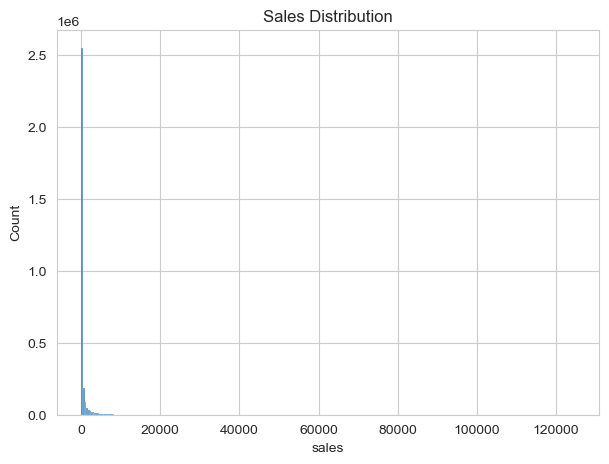

In [72]:
# Sales Plot
sales_clean = merged_df['sales'].dropna()

plt.figure(figsize=(7,5))
sb.histplot(x=sales_clean, bins=300)
plt.title('Sales Distribution')
plt.grid(True)
plt.show()

Sales are right skewed, so it was chosen to perform Log 1 transform.

In [74]:
merged_df['sales'] = np.log1p(merged_df['sales'])

### Feature List with Purpose

- `dayofweek`, `is_weekend`  
  → Sales behave differently on weekends

- `month`, `season`  
  → Captures seasonal sales patterns

- `holiday_flg`, `is_big_event`  
  → Boost in sales during special dates (e.g., Christmas)

- `oil_price`, `dcoilwtico`  
  → Economic proxy that may affect buying behavior


## **ML models**

In [76]:
# Separate train and test sets
kaggle_test_df = merged_df[merged_df['is_test'] == 1]
full_train_df = merged_df[merged_df['is_test'] == 0]

In [77]:
# Compute index to split 80/20
split_index = int(len(full_train_df) * 0.8)

# 80% train, 20% validation
train = full_train_df.iloc[:split_index]
valid = full_train_df.iloc[split_index:]

# Separate features/targets
drop_cols = ['date', 'sales', 'is_test']

X_train = train.drop(columns=drop_cols)
y_train = train['sales']

X_valid = valid.drop(columns=drop_cols)
y_valid = valid['sales']

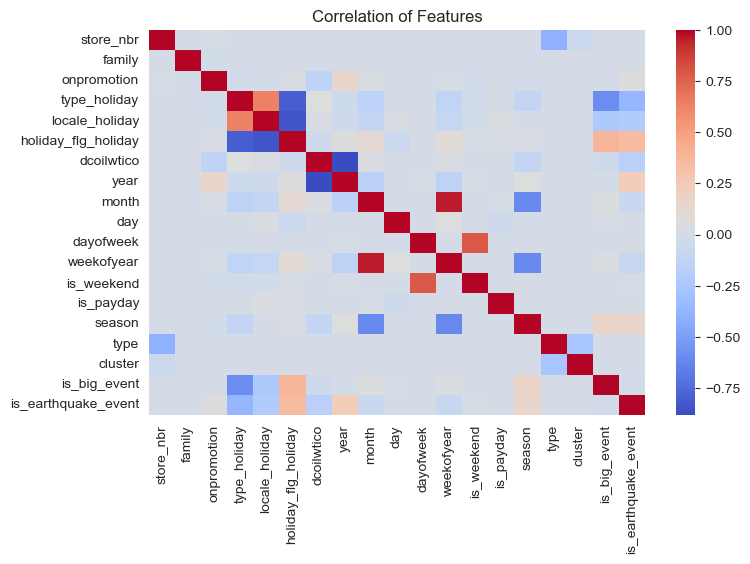

In [78]:
# Plot correlation
plt.figure(figsize=(8, 5))
sb.heatmap(X_train.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation of Features')
plt.show()

### XGB

In [80]:
# Train XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.9, colsample_bytree=0.8, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# Predict on validation
valid_preds_log = xgb_model.predict(X_valid)
valid_preds = np.expm1(valid_preds_log)
valid_preds = np.clip(valid_preds, 0, None)

# Evaluate metrics
rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_valid), valid_preds))
r2 = r2_score(np.expm1(y_valid), valid_preds)

print(f"Validation RMSLE: {rmsle:.5f}")
print(f"Validation R2: {r2:.4f}")

Validation RMSLE: 0.74001
Validation R2: 0.8559


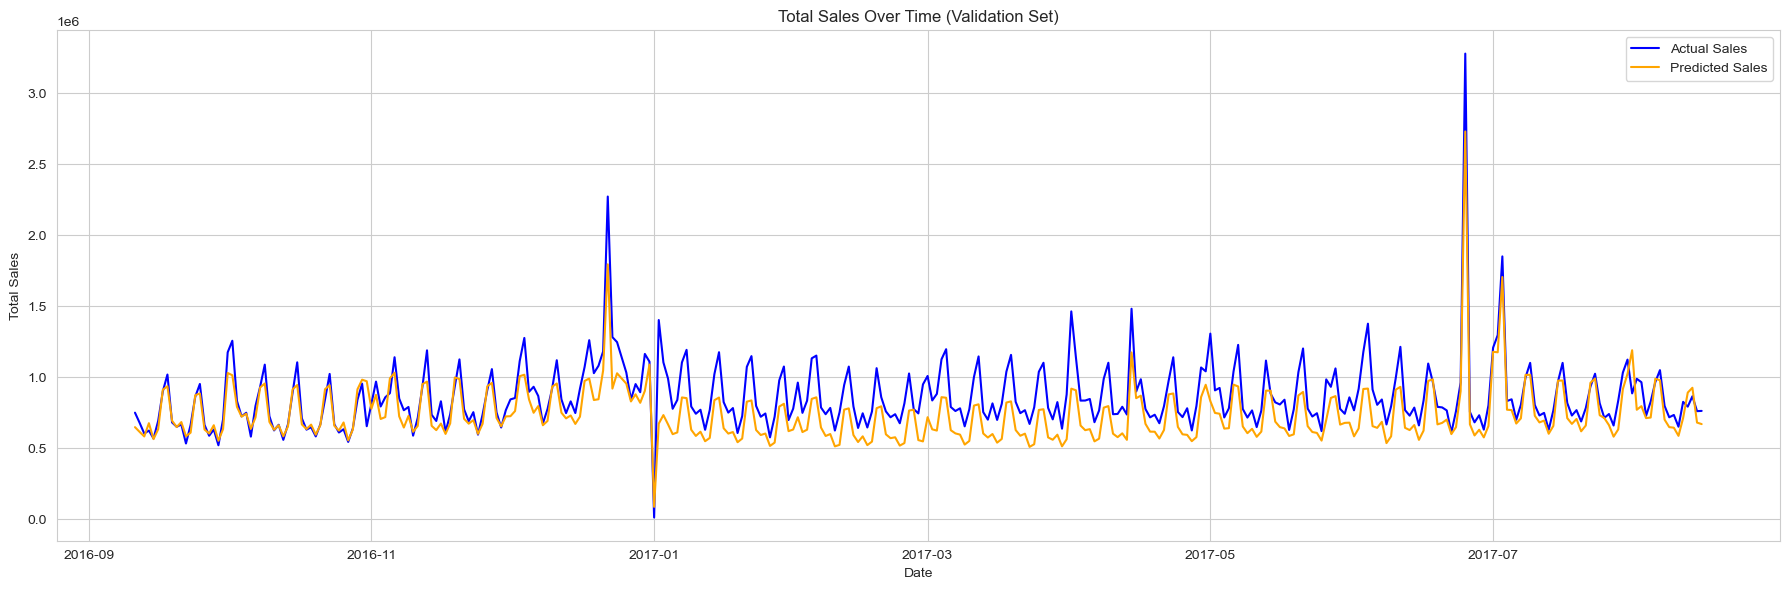

In [81]:
# Lineplot
dates_valid = full_train_df.iloc[split_index:]['date']

# Build compare DataFrame
compare_df = pd.DataFrame({
    'date': valid['date'].values,
    'actual_sales': np.expm1(y_valid),
    'predicted_sales': (valid_preds)})

# Group by date
grouped = compare_df.groupby('date').sum()

plt.figure(figsize=(18,6))
plt.plot(grouped.index, grouped['actual_sales'], label='Actual Sales', color='blue')
plt.plot(grouped.index, grouped['predicted_sales'], label='Predicted Sales', color='orange')
plt.title('Total Sales Over Time (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
# Predict xgb in test csv for kaggle
X_test_kaggle = kaggle_test_df.drop(columns=drop_cols)
test_preds_log = xgb_model.predict(X_test_kaggle)
test_preds = np.expm1(test_preds_log) # Undo log1p transformation
test_preds = np.clip(test_preds, 0, None)

# Create submission file
submission = pd.DataFrame({'id': kaggle_test_df.index, 'sales': test_preds})
submission = submission.sort_values(by='id').reset_index(drop=True)
submission.to_csv('submission_xgb.csv', index=False)

#### XGB improvements with RandomizedSearchCV

In [109]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error, make_scorer
from math import sqrt
import numpy as np

# RMSLE scorer
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Focused param search
param_dist = {
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1.0, 1.5, 2.0],
    'min_child_weight': [1, 3, 5]
}

base_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror'
}

xgb = XGBRegressor(**base_params)
tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring=rmsle_scorer,
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_xgb = search.best_estimator_
print("Best parameters (focused tuning):", search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters (focused tuning): {'reg_lambda': 1.5, 'reg_alpha': 0.5, 'min_child_weight': 5, 'gamma': 0.3}


In [113]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_log_error
from xgboost import XGBRegressor

# Custom scorer
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Param space for main params only
param_dist = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.03, 0.05],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 1.0]
}

# Fixed secondary parameters
base_model = XGBRegressor(
    reg_lambda=1.5,
    reg_alpha=0.5,
    min_child_weight=5,
    gamma=0.3,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring=rmsle_scorer,
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

search.fit(X_train, y_train)
print("Best tuning for core params:", search.best_params_)
best_model = search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best tuning for core params: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.03, 'colsample_bytree': 1.0}


Using hyperparameters to built the best XGB model:


Final Tuned XGB Model:
Validation RMSLE: 0.68291
Validation RMSE: 430.62
Validation R²: 0.9006


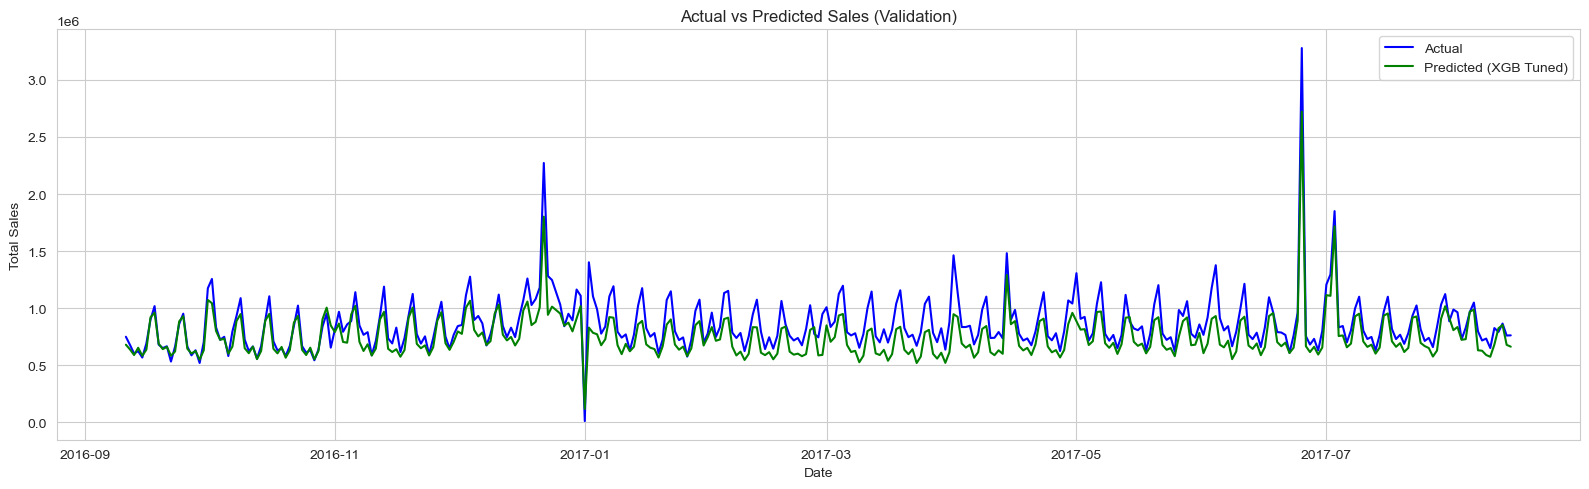

In [121]:
# === Final XGBoost Model ===
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from math import sqrt

# --- Build model with full set of best parameters ---
xgb_best_model = XGBRegressor(n_estimators=500, learning_rate=0.03, max_depth=8, subsample=0.9, colsample_bytree=1.0,
    reg_lambda=1.5, reg_alpha=0.5, min_child_weight=5, gamma=0.3, random_state=42, n_jobs=-1, objective='reg:squarederror')

# --- Train model ---
xgb_best_model.fit(X_train, y_train)

# --- Predict on validation ---
valid_preds_log = xgb_best_model.predict(X_valid)
valid_preds = np.expm1(valid_preds_log)
valid_preds = np.clip(valid_preds, 0, None)
actual_valid = np.expm1(y_valid)

# --- Metrics ---
rmsle = sqrt(mean_squared_log_error(actual_valid, valid_preds))
rmse = sqrt(mean_squared_error(actual_valid, valid_preds))
r2 = r2_score(actual_valid, valid_preds)

print(f"\nFinal Tuned XGB Model:")
print(f"Validation RMSLE: {rmsle:.5f}")
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation R²: {r2:.4f}")

# --- Plot: Actual vs Predicted ---
compare_df = pd.DataFrame({
    'date': valid['date'].values,
    'actual_sales': actual_valid,
    'predicted_sales': valid_preds
}).groupby('date').sum()

plt.figure(figsize=(16,5))
plt.plot(compare_df.index, compare_df['actual_sales'], label='Actual', color='blue')
plt.plot(compare_df.index, compare_df['predicted_sales'], label='Predicted (XGB Tuned)', color='green')
plt.title('Actual vs Predicted Sales (Validation)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Predict on test set ---
X_test_kaggle = kaggle_test_df.drop(columns=drop_cols)
test_preds_log = xgb_best_model.predict(X_test_kaggle)
test_preds = np.expm1(test_preds_log)
test_preds = np.clip(test_preds, 0, None)

# --- Create submission file ---
submission = pd.DataFrame({
    'id': kaggle_test_df.index,
    'sales': test_preds
})
submission = submission.sort_values(by='id').reset_index(drop=True)
submission.to_csv('submission_xgb_fully_tuned.csv', index=False)


### LGB with RandomizedSearchCV

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 2442052, number of used features: 19
[LightGBM] [Info] Start training from score 2.778685
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[934]	valid_0's rmse: 0.625349	valid_0's l2: 0.391061
Best parameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 256, 'min_child_samples': 40, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

Validation RMSLE: 0.62535
Validation RMSE: 427.30
Validation R²: 0.9021


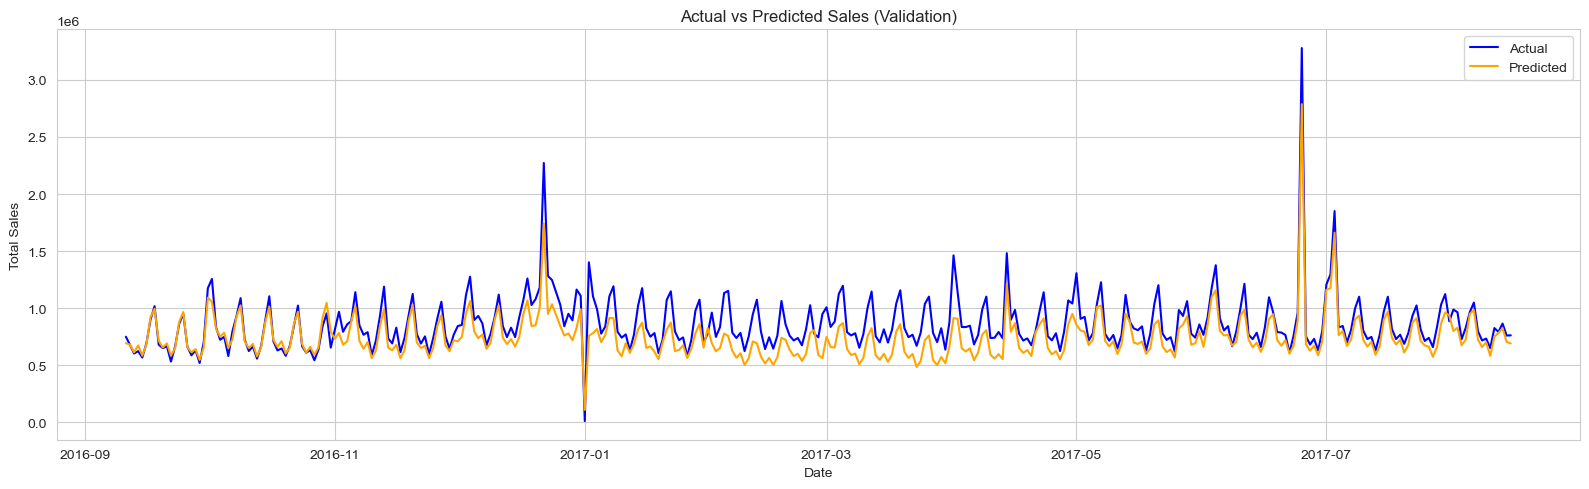

In [84]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Parameters ---
param_dist = {
    'num_leaves': [64, 128, 256],
    'learning_rate': [0.01, 0.02, 0.03, 0.05],
    'max_depth': [-1, 8, 12],
    'min_child_samples': [20, 40, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.5, 1.0],
    'reg_lambda': [0, 0.5, 1.0]
}

# --- Model and CV setup ---
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=2000,  # Usamos early stopping
    random_state=42,
    n_jobs=-1
)

tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# --- Fit search ---
search.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50)],
)

lgb_best_model = search.best_estimator_
print("Best parameters:", search.best_params_)

# --- Predict validation ---
preds_valid = np.expm1(lgb_best_model.predict(X_valid))
actual_valid = np.expm1(y_valid)

# --- Metrics ---
rmsle = np.sqrt(mean_squared_log_error(actual_valid, preds_valid))
rmse = np.sqrt(mean_squared_error(actual_valid, preds_valid))
r2 = r2_score(actual_valid, preds_valid)
print(f"\nValidation RMSLE: {rmsle:.5f}")
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation R²: {r2:.4f}")

# --- Lineplot ---
compare_df = pd.DataFrame({
    'date': valid['date'].values,
    'actual_sales': actual_valid,
    'predicted_sales': preds_valid
}).groupby('date').sum()

plt.figure(figsize=(16,5))
plt.plot(compare_df.index, compare_df['actual_sales'], label='Actual', color='blue')
plt.plot(compare_df.index, compare_df['predicted_sales'], label='Predicted', color='orange')
plt.title('Actual vs Predicted Sales (Validation)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Predict on test set ---
X_test_kaggle = kaggle_test_df.drop(columns=drop_cols)
test_preds = np.expm1(lgb_best_model.predict(X_test_kaggle))
test_preds = np.clip(test_preds, 0, None)

submission = pd.DataFrame({'id': kaggle_test_df.index, 'sales': test_preds})
submission.to_csv('submission_lgb_randomcv.csv', index=False)


#### Improvements: Cross Validation

LightGBM CV (3 folds)
Fold 1 RMSE: 568.16
Fold 2 RMSE: 643.39
Fold 3 RMSE: 681.39
Mean CV RMSE: 630.98 ± 47.05

Training on full training set...

Validation RMSLE: 0.61974
Validation RMSE: 422.04
Validation R²: 0.9045


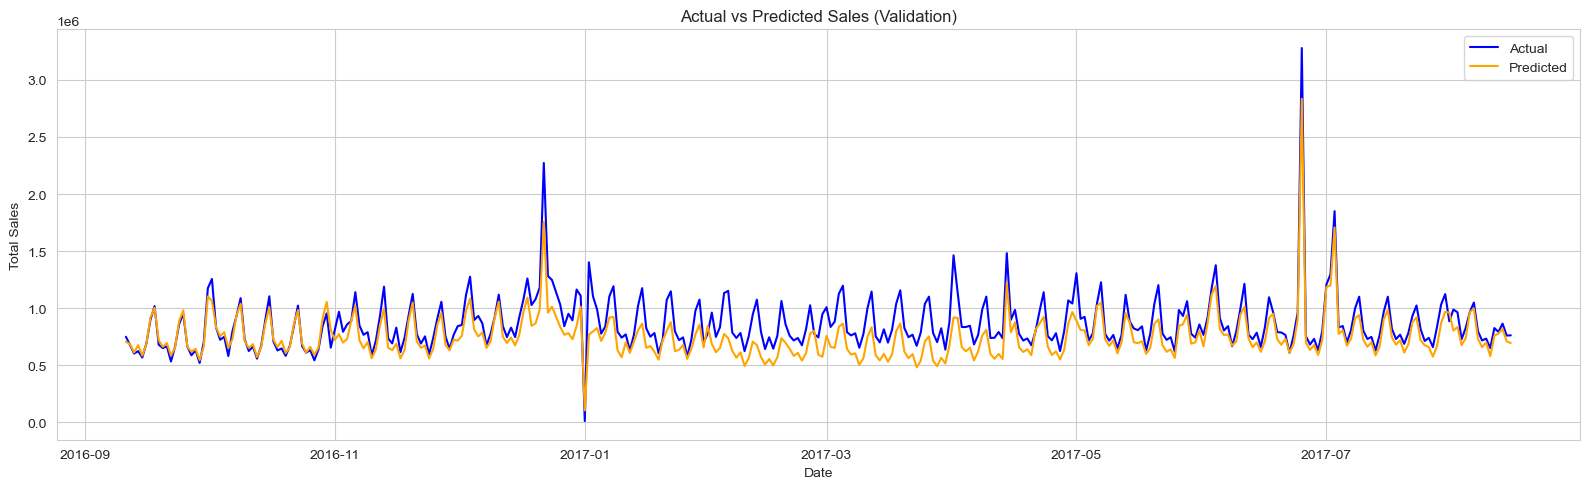

In [90]:
# LGB + CV with the random search best parameters
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from math import sqrt

# --- Best params from RandomizedSearchCV ---
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 256,
    'max_depth': 12,
    'min_child_samples': 40,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'verbosity': -1,
    'seed': 42,
    'n_jobs': -1
}

# === Cross-validation ===
print("LightGBM CV (3 folds)")
tscv = TimeSeriesSplit(n_splits=3)
cv_rmses = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dval = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(
        lgb_params,
        dtrain,
        valid_sets=[dval],
        num_boost_round=2000,
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )

    preds = np.expm1(model.predict(X_val, num_iteration=model.best_iteration))
    actuals = np.expm1(y_val)
    rmse = sqrt(mean_squared_error(actuals, preds))
    cv_rmses.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:.2f}")

print(f"Mean CV RMSE: {np.mean(cv_rmses):.2f} ± {np.std(cv_rmses):.2f}")

# === Final model on full training set ===
print("\nTraining on full training set...")
train_data = lgb.Dataset(X_train, label=y_train)
lgb_best_cv = lgb.train(lgb_params, train_data, num_boost_round=2000)

# === Validation prediction ===
preds_valid = np.expm1(lgb_best_cv.predict(X_valid))
actual_valid = np.expm1(y_valid)

rmsle = sqrt(mean_squared_log_error(actual_valid, preds_valid))
rmse = sqrt(mean_squared_error(actual_valid, preds_valid))
r2 = r2_score(actual_valid, preds_valid)

print(f"\nValidation RMSLE: {rmsle:.5f}")
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation R²: {r2:.4f}")

# === Plot actual vs predicted ===
daily_df = pd.DataFrame({
    'date': valid['date'].values,
    'actual_sales': actual_valid,
    'predicted_sales': preds_valid
}).groupby('date').sum()

plt.figure(figsize=(16,5))
plt.plot(daily_df.index, daily_df['actual_sales'], label='Actual', color='blue')
plt.plot(daily_df.index, daily_df['predicted_sales'], label='Predicted', color='orange')
plt.title('Actual vs Predicted Sales (Validation)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Final test prediction ===
X_test_kaggle = kaggle_test_df.drop(columns=drop_cols)
test_preds_log = lgb_best_cv.predict(X_test_kaggle)
test_preds = np.expm1(test_preds_log)
test_preds = np.clip(test_preds, 0, None)

# === Submission ===
submission = pd.DataFrame({'id': kaggle_test_df.index, 'sales': test_preds})
submission = submission.sort_values(by='id').reset_index(drop=True)
submission.to_csv('submission_lgb_cv.csv', index=False)


### Blended model: XGB + Best LGB (50/50)


Blended Model Performance on Validation Set:
RMSLE: 0.64475
R²: 0.8883


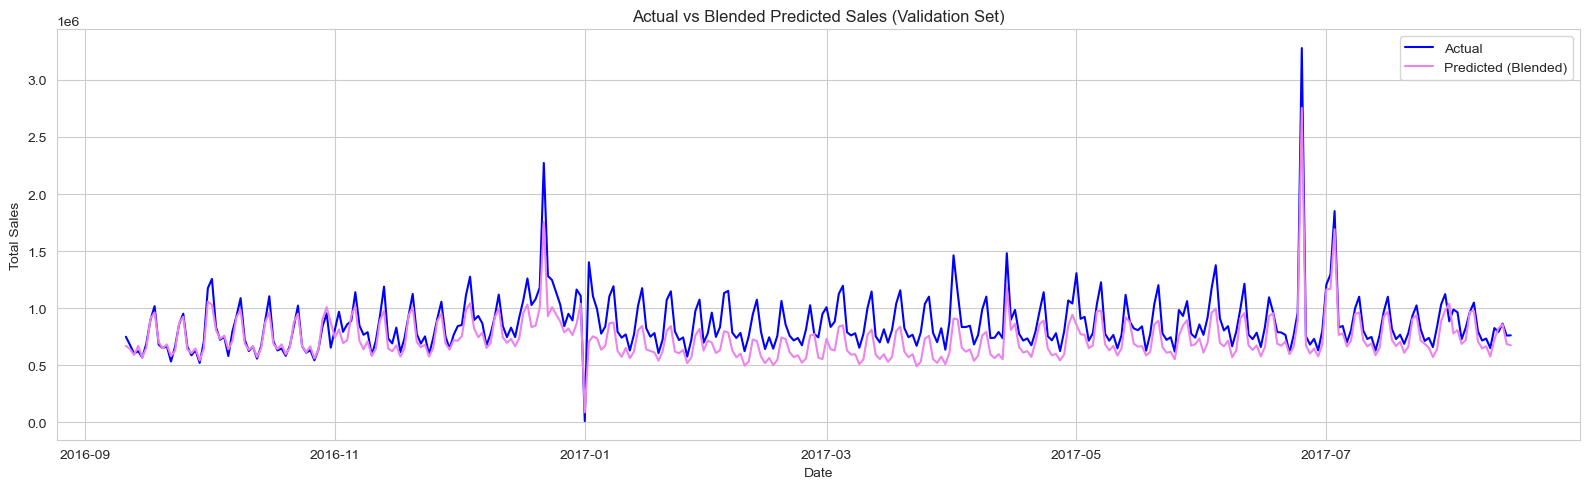

In [156]:
# === Blend XGBoost + LightGBM (best CV model) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from math import sqrt

# === Predict on validation set ===
xgb_preds_log = xgb_model.predict(X_valid)
lgb_preds_log = lgb_best_cv.predict(X_valid, num_iteration=lgb_best_cv.best_iteration)

# === Blended prediction in log scale ===
blended_log_preds = xgb_preds_log * 0.5 + lgb_preds_log * 0.5

# === Convert back from log ===
actual = np.expm1(y_valid)
predicted = np.expm1(blended_log_preds)
predicted = np.clip(predicted, 0, None)

# === Metrics ===
rmsle = sqrt(mean_squared_log_error(actual, predicted))
r2 = r2_score(actual, predicted)

print(f"\nBlended Model Performance on Validation Set:")
print(f"RMSLE: {rmsle:.5f}")
print(f"R²: {r2:.4f}")

# === Plot actual vs predicted (daily sum) ===
compare_df = pd.DataFrame({
    'date': valid['date'].values,
    'actual_sales': actual,
    'predicted_sales': predicted
}).groupby('date').sum()

plt.figure(figsize=(16,5))
plt.plot(compare_df.index, compare_df['actual_sales'], label='Actual', color='blue')
plt.plot(compare_df.index, compare_df['predicted_sales'], label='Predicted (Blended)', color='violet')
plt.title('Actual vs Blended Predicted Sales (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Predict on test set ===
X_test_kaggle = kaggle_test_df.drop(columns=drop_cols)
xgb_test_log = xgb_model.predict(X_test_kaggle)
lgb_test_log = lgb_best_cv.predict(X_test_kaggle, num_iteration=lgb_best_cv.best_iteration)
blended_test_log = xgb_test_log * 0.5 + lgb_test_log * 0.5
blended_test_preds = np.expm1(blended_test_log)
blended_test_preds = np.clip(blended_test_preds, 0, None)

# === Submission ===
submission = pd.DataFrame({
    'id': kaggle_test_df.index,
    'sales': blended_test_preds
})
submission = submission.sort_values(by='id').reset_index(drop=True)
submission.to_csv('submission_blended_best.csv', index=False)

## Final model Insights

* Although we performed RandomizedSearchCV to optimize XGBoost hyperparameters, the final tuned model did not outperform the default one when submitted to Kaggle.
* The untuned XGBoost model with good default settings (n_estimators=500, max_depth=6, learning_rate=0.05, etc.) gave more stable and reliable results on the private leaderboard.
* On the other hand, the LightGBM model, which was trained using cross-validation and tuned parameters, achieved better performance both locally and on Kaggle.
* Our final submission used the base XGBoost model + fully tuned LightGBM (CV) for prediction.
* The final RMSLE score on Kaggle was 0.66, which shows that sometimes simpler models with strong baseline parameters can generalize better, especially on unseen data.